<a href="https://colab.research.google.com/github/nikitanaumenkoo/python-analytics-project/blob/main/Data_analysis_(portfolio_project_1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **1. Підключення до бази даних**


In [ ]:
!pip install --upgrade google-cloud-bigquery pandas numpy matplotlib seaborn db-dtypes scikit-posthocs

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import auth
from google.cloud import bigquery
from scipy.stats import pearsonr

In [ ]:
auth.authenticate_user()
client = bigquery.Client(project="data-analytics-mate")

### **2. Створення датасету**


In [ ]:
sql_query = """
SELECT
   s.date,
   s.ga_session_id,
   sp.continent,
   sp.country,
   sp.device,
   sp.browser,
   sp.mobile_model_name,
   sp.operating_system,
   CASE
    WHEN sp.language LIKE 'en%' THEN 'English'
    WHEN sp.language LIKE 'es%' THEN 'Spanish'
    WHEN sp.language LIKE 'zh%' THEN 'Chinese'
    WHEN sp.language LIKE 'de%' THEN 'German'
    WHEN sp.language LIKE 'fr%' THEN 'French'
    WHEN sp.language LIKE 'ko%' THEN 'Korean'
    ELSE sp.language
   END AS language,
   sp.medium,
   sp.channel,
   acs.account_id,
   a.is_verified,
   a.is_unsubscribed,
   p.category,
   p.name,
   p.price,
   p.short_description
FROM `data-analytics-mate.DA.session` s
left join `DA.session_params` sp
on s.ga_session_id = sp.ga_session_id
left join `DA.account_session` acs
on s.ga_session_id = acs.ga_session_id
left join `DA.account` a
on acs.account_id = a.id
left join `DA.order` o
on s.ga_session_id = o.ga_session_id
left join `DA.product` p
on o.item_id = p.item_id
"""

sales_df = client.query(sql_query).to_dataframe()


### **3. Опис датасету**

In [ ]:
sales_df.head()

,date,ga_session_id,continent,country,device,browser,mobile_model_name,operating_system,language,medium,channel,account_id,is_verified,is_unsubscribed,category,name,price,short_description
0,2020-11-01,5760483956,Americas,United States,desktop,Chrome,Safari,Macintosh,Chinese,<Other>,Paid Search,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
1,2020-11-01,7115337200,Europe,United Kingdom,desktop,Chrome,Chrome,Web,English,organic,Organic Search,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
2,2020-11-01,3978035233,Europe,Norway,mobile,Chrome,<Other>,Web,Chinese,(none),Direct,<NA>,<NA>,<NA>,Tables & desks,RÅSKOG,189.0,"Trolley, 35x45x78 cm"
3,2020-11-01,9648986282,Africa,Nigeria,mobile,Chrome,<Other>,Android,Spanish,(none),Direct,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
4,2020-11-01,4393441533,Asia,China,desktop,Chrome,Chrome,Windows,English,(none),Direct,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"


In [ ]:
# Вивід опису датасету sales_df
print("--- 1. Загальний огляд (Типи даних, Non-Null Values, Загальна кількість) ---")
sales_df.info()

--- 1. Загальний огляд (Типи даних, Non-Null Values, Загальна кількість) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349545 entries, 0 to 349544
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   date               349545 non-null  dbdate 
 1   ga_session_id      349545 non-null  Int64  
 2   continent          349545 non-null  object 
 3   country            349545 non-null  object 
 4   device             349545 non-null  object 
 5   browser            349545 non-null  object 
 6   mobile_model_name  349545 non-null  object 
 7   operating_system   349545 non-null  object 
 8   language           235279 non-null  object 
 9   medium             349545 non-null  object 
 10  channel            349545 non-null  object 
 11  account_id         27945 non-null   Int64  
 12  is_verified        27945 non-null   Int64  
 13  is_unsubscribed    27945 non-null   Int64  
 14  category           3353

In [ ]:
print("\n--- 2. Статистичний огляд числових колонок ---")
print(sales_df.describe().T)

print("\n--- 3. Перевірка пропущених значень (NULLs) ---")
# Підрахунок кількості NULL-значень у кожній колонці
missing_data = sales_df.isnull().sum()
# Виводимо лише ті колонки, де є пропуски, і сортуємо їх за кількістю
missing_data_present = missing_data[missing_data > 0].sort_values(ascending=False)
print(missing_data_present)

print("\n--- 4. Унікальні значення та часовий період ---")
# Кількість унікальних сесій
unique_sessions = sales_df['ga_session_id'].nunique()
print(f"Кількість унікальних сесій: {unique_sessions}")

# Перевірка часового періоду
sales_df['date'] = pd.to_datetime(sales_df['date'])
min_date = sales_df['date'].min()
max_date = sales_df['date'].max()
print(f"Період даних: від {min_date.date()} до {max_date.date()}")


--- 2. Статистичний огляд числових колонок ---
                    count               mean                std       min  \
ga_session_id    349545.0  4992250296.631739  2887450949.537772    1205.0   
account_id        27945.0      659005.065557       13216.529465  636133.0   
is_verified       27945.0            0.71698           0.450474       0.0   
is_unsubscribed   27945.0            0.16944           0.375147       0.0   
price             33538.0         953.298679        1317.001775       3.0   

                          25%           50%           75%           max  
ga_session_id    2493646855.0  4988476074.0  7491286508.0  9999997129.0  
account_id           647576.0      658952.0      670414.0      681962.0  
is_verified               0.0           1.0           1.0           1.0  
is_unsubscribed           0.0           0.0           0.0           1.0  
price                   170.0         445.0        1195.0        9585.0  

--- 3. Перевірка пропущених значень (NULLs) 

#### Датасет складається з 18 колонок:
* 5 числових (ga_session_id, account_id, is_verified, is_unsubscribed, price)
* 12 категоріальних (continent, country, device, browser, mobile_model_name, operating_system, language, medium, channel, category, name, short_description)
* 1 дати та часу (date)
#### Кількість унікальних сесій - 349545. Датасет охолює період з 01.11.2020 до 31.01.2021. Стовпці account_id, is_verified, is_unsubscribed, category, price,name, short_description, language мають пропущені значення. Основна причина пропущених значень - незареєстровані користувачі.         





### **4. Загальний аналіз даних**

### 1) Топ континентів та країн за продажами та кількістю замовлень


In [ ]:
# Агрегація даних за континентами
continent_analysis = sales_df.groupby('continent').agg(
    Total_Sales=('price', 'sum'),
    Total_Orders=('ga_session_id', 'nunique')
).reset_index()

# 1. Топ-3 за Виручкою (Total_Sales)
top3_sales_continent = continent_analysis.sort_values(
    by='Total_Sales', ascending=False
).head(3)
print("--- Топ-3 Континенти за Виручкою ---")
print(top3_sales_continent)

# 2. Топ-3 за Кількістю Замовлень (Total_Orders)
top3_orders_continent = continent_analysis.sort_values(
    by='Total_Orders', ascending=False
).head(3)
print("\n--- Топ-3 Континенти за Кількістю Замовлень ---")
print(top3_orders_continent)

--- Топ-3 Континенти за Виручкою ---
  continent  Total_Sales  Total_Orders
2  Americas   17665280.0        193179
3      Asia    7601298.3         83113
4    Europe    5934624.2         65135

--- Топ-3 Континенти за Кількістю Замовлень ---
  continent  Total_Sales  Total_Orders
2  Americas   17665280.0        193179
3      Asia    7601298.3         83113
4    Europe    5934624.2         65135


In [ ]:
# Агрегація даних за країнами
country_analysis = sales_df.groupby('country').agg(
    Total_Sales=('price', 'sum'),
    Total_Orders=('ga_session_id', 'nunique')
).reset_index()

# 1. Топ-5 за Виручкою (Total_Sales)
top5_sales_country = country_analysis.sort_values(
    by='Total_Sales', ascending=False
).head(5)
print("--- Топ-5 Країн за Виручкою ---")
print(top5_sales_country)

# 2. Топ-5 за Кількістю Замовлень (Total_Orders)
top5_orders_country = country_analysis.sort_values(
    by='Total_Orders', ascending=False
).head(5)
print("\n--- Топ-5 Країн за Кількістю Замовлень ---")
print(top5_orders_country)

--- Топ-5 Країн за Виручкою ---
            country  Total_Sales  Total_Orders
104   United States   13943553.9        153470
43            India    2809762.0         32763
18           Canada    2437921.0         25994
103  United Kingdom     938317.9         11003
33           France     710692.8          6958

--- Топ-5 Країн за Кількістю Замовлень ---
            country  Total_Sales  Total_Orders
104   United States   13943553.9        153470
43            India    2809762.0         32763
18           Canada    2437921.0         25994
103  United Kingdom     938317.9         11003
33           France     710692.8          6958


Візуалізація

/tmp/ipython-input-1751930400.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-1751930400.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-1751930400.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-1751930400.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


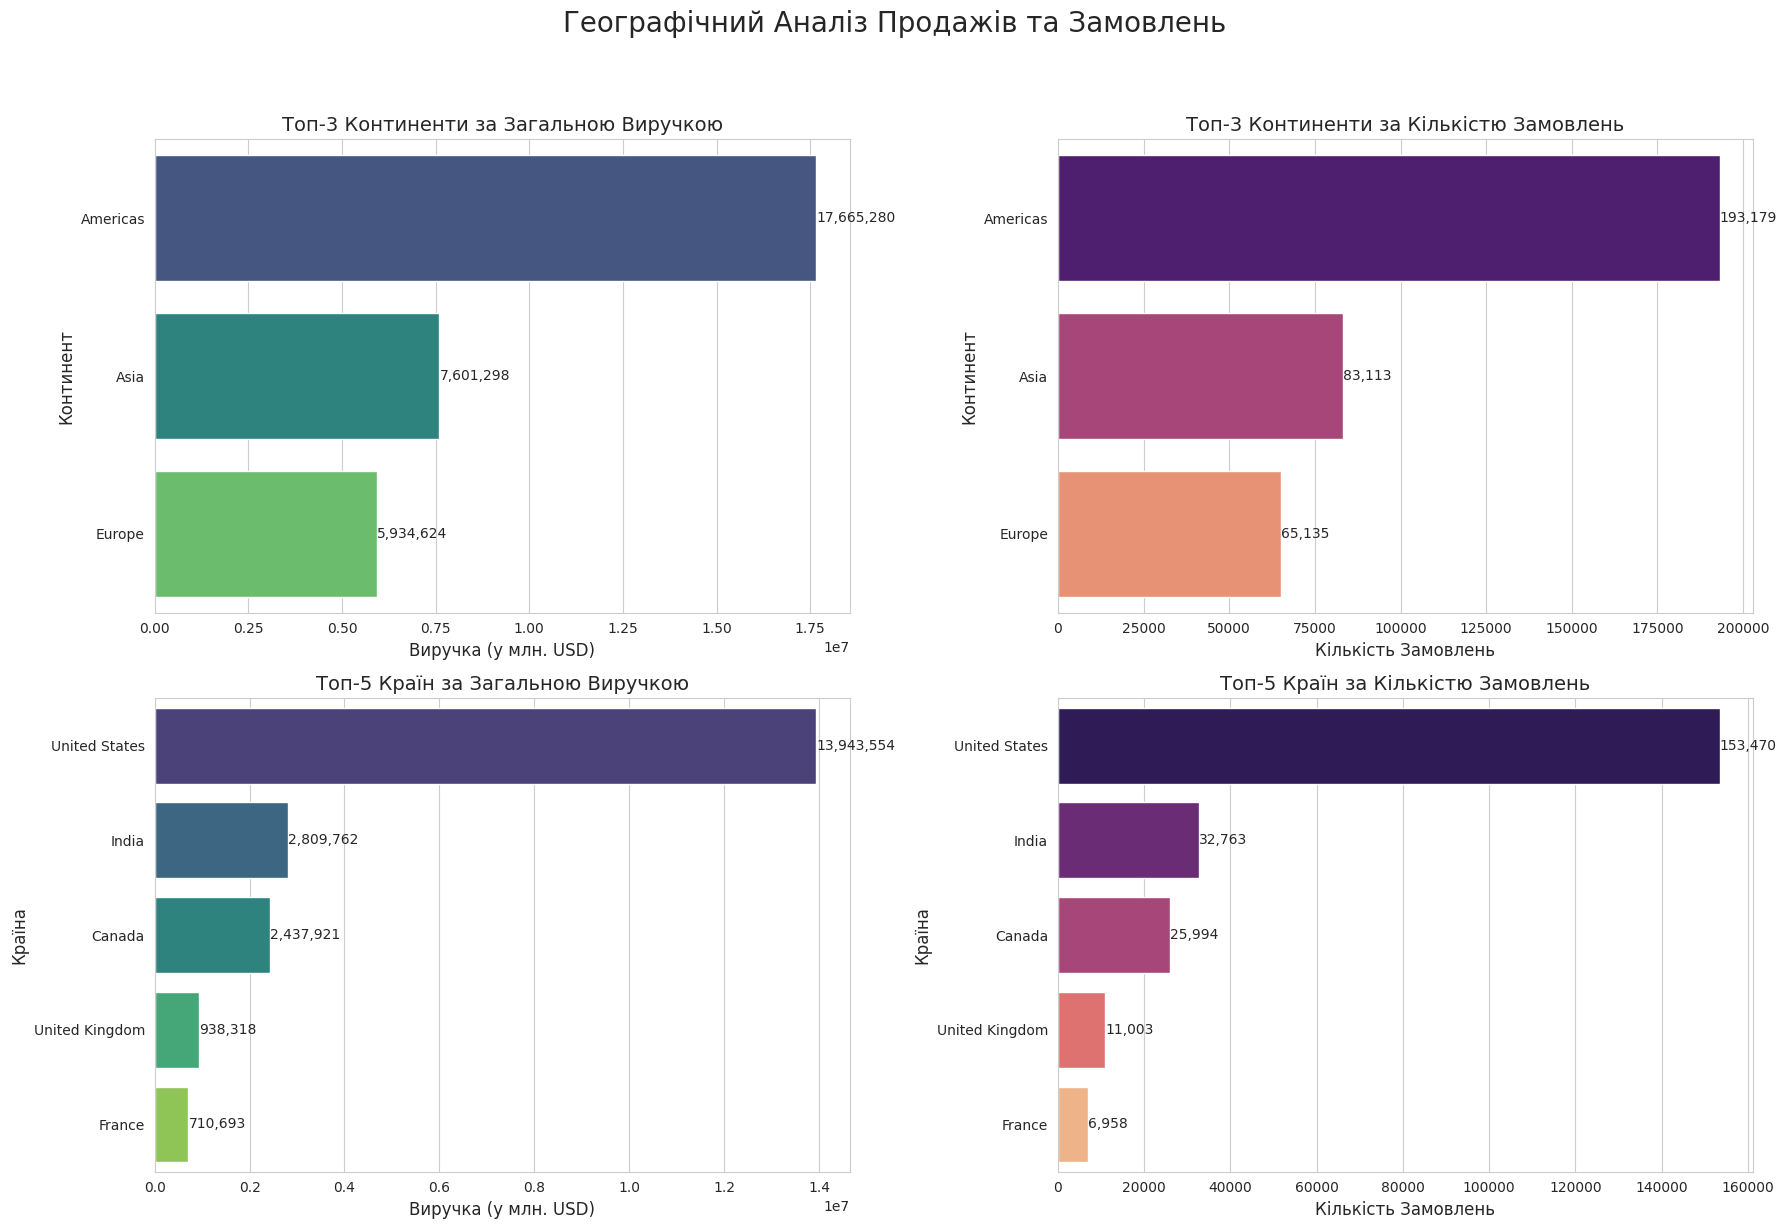

In [ ]:
# Налаштування стилю для графіків
sns.set_style("whitegrid")

# Створюємо фігуру
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
plt.suptitle('Географічний Аналіз Продажів та Замовлень', fontsize=20, y=1.02)

# --- 1. ТОП-3 КОНТИНЕНТИ ЗА ВИРУЧКОЮ ---
sns.barplot(
    x='Total_Sales',
    y='continent',
    data=top3_sales_continent,
    ax=axes[0, 0],
    palette='viridis'
)
axes[0, 0].set_title('Топ-3 Континенти за Загальною Виручкою', fontsize=14)
axes[0, 0].set_xlabel('Виручка (у млн. USD)', fontsize=12)
axes[0, 0].set_ylabel('Континент', fontsize=12)

# Додавання значень на стовпці
for index, value in enumerate(top3_sales_continent['Total_Sales']):
    axes[0, 0].text(value, index, f'{value:,.0f}', va='center')


# --- 2. ТОП-3 КОНТИНЕНТИ ЗА ЗАМОВЛЕННЯМИ ---
sns.barplot(
    x='Total_Orders',
    y='continent',
    data=top3_orders_continent,
    ax=axes[0, 1],
    palette='magma'
)
axes[0, 1].set_title('Топ-3 Континенти за Кількістю Замовлень', fontsize=14)
axes[0, 1].set_xlabel('Кількість Замовлень', fontsize=12)
axes[0, 1].set_ylabel('Континент', fontsize=12)

for index, value in enumerate(top3_orders_continent['Total_Orders']):
    axes[0, 1].text(value, index, f'{value:,.0f}', va='center')


# --- 3. ТОП-5 КРАЇН ЗА ВИРУЧКОЮ ---
sns.barplot(
    x='Total_Sales',
    y='country',
    data=top5_sales_country,
    ax=axes[1, 0],
    palette='viridis'
)
axes[1, 0].set_title('Топ-5 Країн за Загальною Виручкою', fontsize=14)
axes[1, 0].set_xlabel('Виручка (у млн. USD)', fontsize=12)
axes[1, 0].set_ylabel('Країна', fontsize=12)

for index, value in enumerate(top5_sales_country['Total_Sales']):
    axes[1, 0].text(value, index, f'{value:,.0f}', va='center')


# --- 4. ТОП-5 КРАЇН ЗА ЗАМОВЛЕННЯМИ ---
sns.barplot(
    x='Total_Orders',
    y='country',
    data=top5_orders_country,
    ax=axes[1, 1],
    palette='magma'
)
axes[1, 1].set_title('Топ-5 Країн за Кількістю Замовлень', fontsize=14)
axes[1, 1].set_xlabel('Кількість Замовлень', fontsize=12)
axes[1, 1].set_ylabel('Країна', fontsize=12)

for index, value in enumerate(top5_orders_country['Total_Orders']):
    axes[1, 1].text(value, index, f'{value:,.0f}', va='center')

# Забезпечення акуратного вигляду та уникнення накладок
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

### 2) Топ-10 категорій товарів за загальною сумою продажів


In [ ]:
# 1. Агрегація
category_sales = sales_df.groupby('category').agg(
    Total_Revenue=('price', 'sum')
).reset_index()

# 2. Сортування
top10_categories = category_sales.sort_values(
    by='Total_Revenue',
    ascending=False
).head(10)

print("--- Топ-10 Категорій Товарів за Загальною Сумою Продажів ---")
print(top10_categories)

--- Топ-10 Категорій Товарів за Загальною Сумою Продажів ---
                            category  Total_Revenue
12                 Sofas & armchairs      8388254.5
5                             Chairs      6147748.8
1                               Beds      4919725.0
2         Bookcases & shelving units      3640818.1
3               Cabinets & cupboards      2336499.5
9                  Outdoor furniture      2142222.2
13                    Tables & desks      1790307.5
6   Chests of drawers & drawer units       906562.5
0                      Bar furniture       735503.0
7               Children's furniture       467697.0


Візуалізація

/tmp/ipython-input-567593269.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


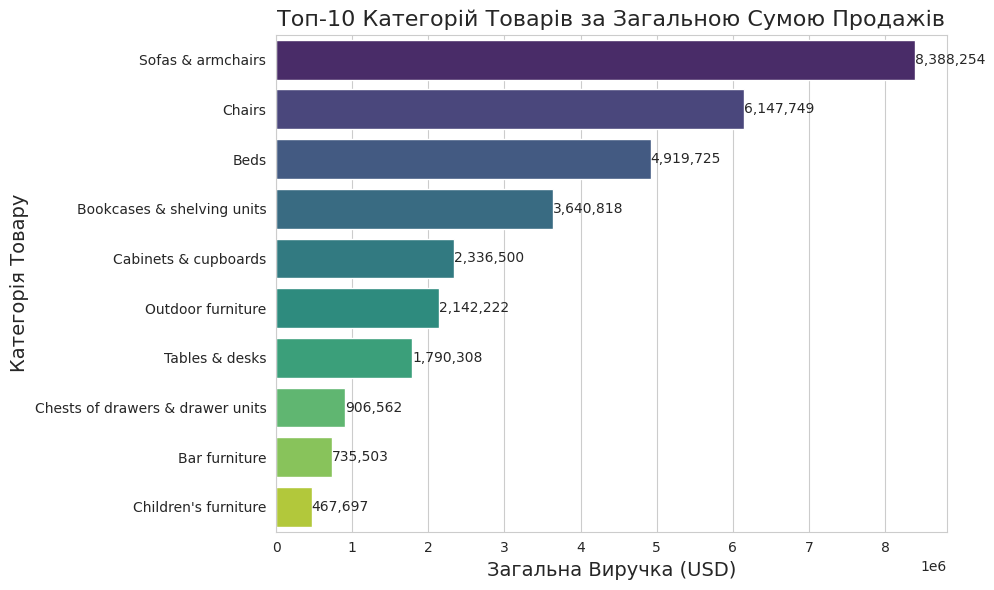

In [ ]:
# Налаштування стилю
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Створення горизонтальної стовпчастої діаграми
sns.barplot(
    x='Total_Revenue',
    y='category',
    data=top10_categories,
    palette='viridis'
)

# Заголовок та підписи осей
plt.title('Топ-10 Категорій Товарів за Загальною Сумою Продажів', fontsize=16)
plt.xlabel('Загальна Виручка (USD)', fontsize=14)
plt.ylabel('Категорія Товару', fontsize=14)

# Додавання значень виручки на стовпці для точності
for index, value in enumerate(top10_categories['Total_Revenue']):
    plt.text(value, index, f'{value:,.0f}', va='center') # Форматування числа з роздільниками

# Забезпечення акуратного вигляду
plt.tight_layout()
plt.show()

### 3) Топ-10 категорій товарів у країні з найбільшими продажами


In [ ]:
# 1. Фільтрація
df_us = sales_df[sales_df['country'] == 'United States'].copy()

# 2. Агрегація
us_category_sales = df_us.groupby('category').agg(
    US_Total_Revenue=('price', 'sum')
).reset_index()

# 3. Сортування
top10_us_categories = us_category_sales.sort_values(
    by='US_Total_Revenue',
    ascending=False
).head(10)

print("\n--- Топ-10 Категорій Товарів за Сумою Продажів у США ---")
print(top10_us_categories)


--- Топ-10 Категорій Товарів за Сумою Продажів у США ---
                            category  US_Total_Revenue
12                 Sofas & armchairs         3707144.5
5                             Chairs         2619773.8
1                               Beds         2213058.0
2         Bookcases & shelving units         1567606.9
3               Cabinets & cupboards          994545.5
9                  Outdoor furniture          929245.2
13                    Tables & desks          777865.0
6   Chests of drawers & drawer units          382388.0
0                      Bar furniture          330805.0
7               Children's furniture          207575.0


Ми бачимо, що категорії повністю співпадають із топ-10 категорій за загальною сумою продаж.

### 4) Продажі у розрізі типів та моделей девайсів

In [ ]:
# Розрахунок загальної суми продажів
overall_total_sales = sales_df['price'].sum()
print(f"Загальна сума продажів у датасеті: {overall_total_sales:,.0f}")

Загальна сума продажів у датасеті: 31,971,731


In [ ]:
# Аналіз за Типом Девайсу

device_sales = sales_df.groupby('device').agg(
    Device_Sales=('price', 'sum')
).reset_index()

# Розрахунок частки у %
device_sales['%_from_total'] = (device_sales['Device_Sales'] / overall_total_sales) * 100

# Сортування
device_sales_ranked = device_sales.sort_values(
    by='%_from_total',
    ascending=False
)

print("\n--- Продажі за Типом Девайсу (device) ---")
print(device_sales_ranked)


--- Продажі за Типом Девайсу (device) ---
    device  Device_Sales  %_from_total
0  desktop    18864039.0     59.002245
1   mobile    12384225.8     38.734924
2   tablet      723466.3      2.262831


In [ ]:
# Аналіз за Моделлю Девайсу

# 1. Фільтрація NULLs
df_models = sales_df.dropna(subset=['mobile_model_name']).copy()

# 2. Агрегація за моделлю
model_sales = df_models.groupby('mobile_model_name').agg(
    Model_Sales=('price', 'sum')
).reset_index()

# 3. Розрахунок частки у %
model_sales['%_from_total'] = (model_sales['Model_Sales'] / overall_total_sales) * 100

# 4. Сортування та вивід Топ-10 моделей
top10_models = model_sales.sort_values(
    by='%_from_total',
    ascending=False
).head(10)

print("\n--- Топ-10 Продажів за Моделлю Девайсу (mobile_model_name) ---")
print(top10_models)


--- Топ-10 Продажів за Моделлю Девайсу (mobile_model_name) ---
  mobile_model_name  Model_Sales  %_from_total
1            Chrome    8899523.9     27.835602
0           <Other>    6535330.8     20.440966
7            Safari    6491062.1     20.302504
9            iPhone    6420776.3     20.082667
2        ChromeBook    1830458.7      5.725241
3              Edge     697222.3      2.180746
8              iPad     448854.2      1.403910
4           Firefox     421066.9      1.316998
6        Pixel 4 XL     118287.7      0.369976
5           Pixel 3     109148.2      0.341390


###5) Продажі за джерелами трафіку

In [ ]:
# Аналіз за Групами Каналів

channel_sales = sales_df.groupby('channel').agg(
    Channel_Sales=('price', 'sum')
).reset_index()

# Розрахунок частки у %
channel_sales['%_from_total'] = (channel_sales['Channel_Sales'] / overall_total_sales) * 100

# Сортування та вивід
channel_sales_ranked = channel_sales.sort_values(
    by='%_from_total',
    ascending=False
)

print("\n--- Продажі за Групою Каналів (channel) ---")
print(channel_sales_ranked)


--- Продажі за Групою Каналів (channel) ---
          channel  Channel_Sales  %_from_total
1  Organic Search     11433151.6     35.760189
2     Paid Search      8511049.4     26.620546
0          Direct      7494923.4     23.442345
3   Social Search      2532105.7      7.919827
4       Undefined      2000501.0      6.257093


In [ ]:
# Аналіз за Джерелом Трафіку

medium_sales = sales_df.groupby('medium').agg(
    Medium_Sales=('price', 'sum')
).reset_index()

# Розрахунок частки у %
medium_sales['%_from_total'] = (medium_sales['Medium_Sales'] / overall_total_sales) * 100

# Сортування та вивід
medium_sales_ranked = medium_sales.sort_values(
    by='%_from_total',
    ascending=False
)

print("\n--- Продажі за Джерелом Трафіку (medium) ---")
print(medium_sales_ranked)


--- Продажі за Джерелом Трафіку (medium) ---
           medium  Medium_Sales  %_from_total
4         organic    10935239.9     34.202840
1          (none)     7494923.4     23.442345
5        referral     5641855.2     17.646386
2         <Other>     4491351.1     14.047882
0  (data deleted)     2041921.0      6.386645
3             cpc     1366440.5      4.273902


### 6) Відсоток зареєстрованих користувачів, які підтвердили свою електронну адресу.

In [ ]:
# Аналіз підтвердження електронної адреси

# 1. Створення DataFrame
registered_users_df = sales_df.dropna(subset=['account_id', 'is_verified']).copy()

# 2. Агрегація унікальних користувачів
total_users = registered_users_df['account_id'].nunique()

verified_users_count = registered_users_df[
    registered_users_df['is_verified'] == True
]['account_id'].nunique()

# 3. Розрахунок відсотка
verification_percentage = (verified_users_count / total_users) * 100

print(f"--- Аналіз Верифікації Електронної Адреси ---")
print(f"Загальна кількість унікальних зареєстрованих користувачів: {total_users:,}")
print(f"Кількість користувачів із підтвердженою адресою: {verified_users_count:,}")
print(f"Відсоток підтверджених електронних адрес: {verification_percentage:.2f}%")

--- Аналіз Верифікації Електронної Адреси ---
Загальна кількість унікальних зареєстрованих користувачів: 27,945
Кількість користувачів із підтвердженою адресою: 20,036
Відсоток підтверджених електронних адрес: 71.70%


### 7) Відсоток зареєстрованих користувачів, які відписались від розсилки.

In [ ]:
# Комірка: Аналіз відписок від розсилки

# 1. Створення DataFrame
registered_users_for_unsub = sales_df.dropna(subset=['account_id', 'is_unsubscribed']).copy()

# 2. Агрегація унікальних користувачів
total_users = registered_users_for_unsub['account_id'].nunique()

unsubscribed_users_count = registered_users_for_unsub[
    registered_users_for_unsub['is_unsubscribed'] == True
]['account_id'].nunique()

# 3. Розрахунок відсотка
unsubscribed_percentage = (unsubscribed_users_count / total_users) * 100

print(f"--- Аналіз Відписок від Email-Розсилки ---")
print(f"Загальна кількість унікальних зареєстрованих користувачів: {total_users:,}")
print(f"Кількість користувачів, які відписалися: {unsubscribed_users_count:,}")
print(f"Відсоток зареєстрованих користувачів, які відписалися: {unsubscribed_percentage:.2f}%")

--- Аналіз Відписок від Email-Розсилки ---
Загальна кількість унікальних зареєстрованих користувачів: 27,945
Кількість користувачів, які відписалися: 4,735
Відсоток зареєстрованих користувачів, які відписалися: 16.94%


### 8) Топ країн з найбільшою кількістю зареєстрованих користувачів.



In [ ]:
# 1. Фільтрація
registered_df = sales_df.dropna(subset=['account_id']).copy()

# 2. Групування
country_users_count = registered_df.groupby('country').agg(
    Unique_Users=('account_id', 'nunique')
).reset_index()

# 3. Сортування: Знаходимо країни з найбільшою кількістю користувачів
top_countries_by_users = country_users_count.sort_values(
    by='Unique_Users',
    ascending=False
).head(10) # Виводимо Топ-10 для повнішої картини

print("--- Топ-10 Країн за Кількістю Зареєстрованих Користувачів ---")
print(top_countries_by_users)

--- Топ-10 Країн за Кількістю Зареєстрованих Користувачів ---
            country  Unique_Users
104   United States         12384
43            India          2687
18           Canada          2067
103  United Kingdom           859
33           France           553
92            Spain           536
96           Taiwan           500
20            China           490
35          Germany           490
48            Italy           386


### 9) Топ мов по використанню

In [ ]:
# 1. Підрахунок кількості сесій для кожної мови
language_counts = sales_df['language'].value_counts(dropna=False)

# 2. Перейменовуємо індекс NaN
language_counts = language_counts.rename({float('nan'): 'Not Specified / Unknown'})

# 3. Розрахунок загальної кількості сесій
total_sessions = sales_df.shape[0]

# 4. Розрахунок частки у %
language_percentage = (language_counts / total_sessions) * 100

# 5. Конвертація у DataFrame для зручного відображення та сортування
language_analysis = language_percentage.reset_index()
language_analysis.columns = ['Language', '%_from_total']

# 6. Сортування та вивід
top_languages = language_analysis.sort_values(
    by='%_from_total',
    ascending=False
).head(10)

print("--- Топ Мов по Використанню (% від загальної кількості сесій) ---")
print(top_languages)

--- Топ Мов по Використанню (% від загальної кількості сесій) ---
  Language  %_from_total
0  English     58.795577
1     None     32.689925
2  Chinese      3.496546
3  Spanish      1.647856
4   French      1.616959
5   German      0.968974
6   Korean      0.784162


### **5. Аналіз динаміки продажів**

### 1) Загальна динаміка продажів.

In [ ]:
# Агрегація
daily_sales = sales_df.groupby('date').agg(
    Daily_Revenue=('price', 'sum')
).reset_index()

Візуалізація

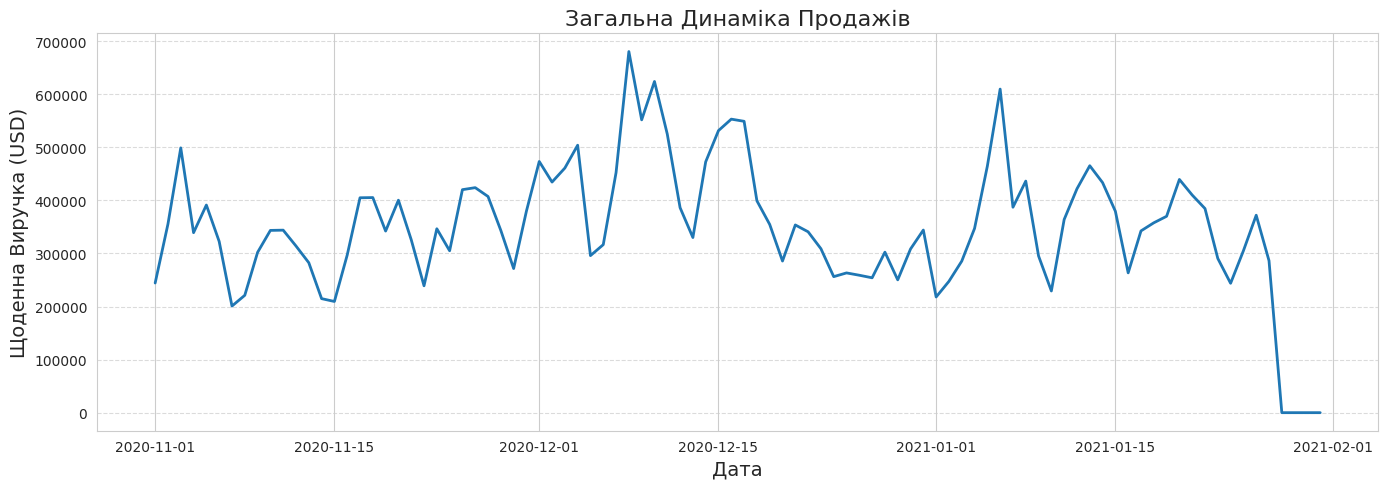

In [ ]:
# Налаштування стилю
sns.set_style("whitegrid")
plt.figure(figsize=(14, 5))

# Побудова лінійного графіку
sns.lineplot(
    x='date',
    y='Daily_Revenue',
    data=daily_sales,
    color='#1f77b4',
    linewidth=2
)

# Заголовок та підписи осей
plt.title('Загальна Динаміка Продажів', fontsize=16)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Щоденна Виручка (USD)', fontsize=14)

# Додаємо сітку по осі Y для кращої читабельності значень
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Забезпечення акуратного вигляду
plt.tight_layout()
plt.show()

На графіку денних продаж спостерігається тижнева сезонність, однак вона не є чітко вираженою через високий рівень коливань та вплив святкових періодів.
Проте, у більшості періодів простежуються повторювані піки та спади з інтервалом близько семи днів, що відповідає тижневому циклу попиту.

###2) Аналіз динаміки продажів в Америці, Азії та Європі.

In [ ]:
# 1. Визначимо точні назви континентів
key_continents = ['Americas', 'Asia', 'Europe']

# 2. Фільтрація даних
df_regional = sales_df[sales_df['continent'].isin(key_continents)].copy()

# 3. Агрегація
daily_continent_sales_final = df_regional.groupby(['date', 'continent']).agg(
    Daily_Revenue=('price', 'sum')
).reset_index()

Візуалізація

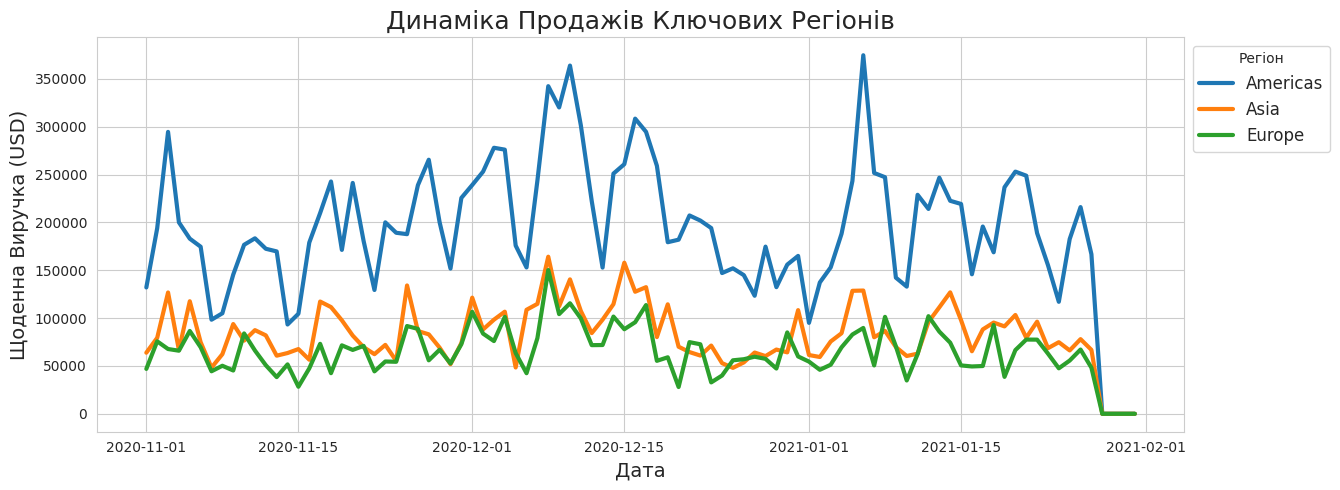

In [ ]:
# Налаштування стилю
sns.set_style("whitegrid")
plt.figure(figsize=(15, 5))

# Побудова лінійного графіку
sns.lineplot(
    x='date',
    y='Daily_Revenue',
    hue='continent', # Кожна лінія - окремий континент
    data=daily_continent_sales_final,
    linewidth=3
)

# Заголовок та підписи осей
plt.title('Динаміка Продажів Ключових Регіонів', fontsize=18)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Щоденна Виручка (USD)', fontsize=14)

# Розташування легенди за межами графіку
plt.legend(title='Регіон', loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

На цьому графіку наглядно видно різницю у продажах між регіонами. Америка суттєво випереджує інші континенти, більшість значень щоденної виручки знаходиться у проміжку між \$150000 та \$300000. Азія випереджає Європу по продажам, більшість значень щоденної виручки знаходиться у проміжку між \$50000 та \$150000, Європа - \$50000 - \$100000.

###3) Аналіз динаміки продажів у розрізі каналів трафіку

In [ ]:
# 1. Фільтрація
df_channel = sales_df.dropna(subset=['channel']).copy()

# 2. Агрегація
daily_channel_sales = df_channel.groupby(['date', 'channel']).agg(
    Daily_Revenue=('price', 'sum')
).reset_index()

Візуалізація

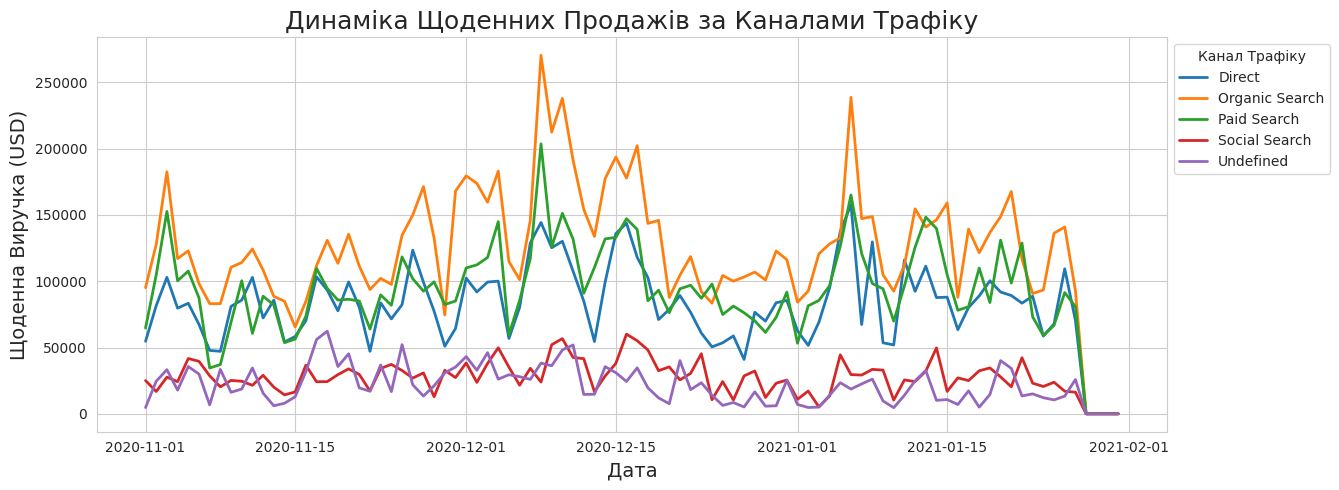

In [ ]:
# Налаштування стилю
sns.set_style("whitegrid")
plt.figure(figsize=(15, 5))

# Побудова лінійного графіку
sns.lineplot(
    x='date',
    y='Daily_Revenue',
    hue='channel',
    data=daily_channel_sales,
    linewidth=2
)

# Заголовок та підписи осей
plt.title('Динаміка Щоденних Продажів за Каналами Трафіку', fontsize=18)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Щоденна Виручка (USD)', fontsize=14)

# Розташування легенди
plt.legend(title='Канал Трафіку', loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

У структурі продажів домінує Organic Search, який є найбільшим джерелом щоденної виручки.\
Канали Paid Search та Direct вносять значну частину доходу та демонструють виражену тижневу й святкову сезонність.\
Канал Social Search знаходиться на останньому місці, роблячи значно менший внесок у загальну виручку.

###4) Аналіз динаміки продажів за типом девайсу

In [ ]:
# 1. Фільтрація
df_device = sales_df.dropna(subset=['device']).copy()

# 2. Агрегація
daily_device_sales = df_device.groupby(['date', 'device']).agg(
    Daily_Revenue=('price', 'sum')
).reset_index()

Візуалізація

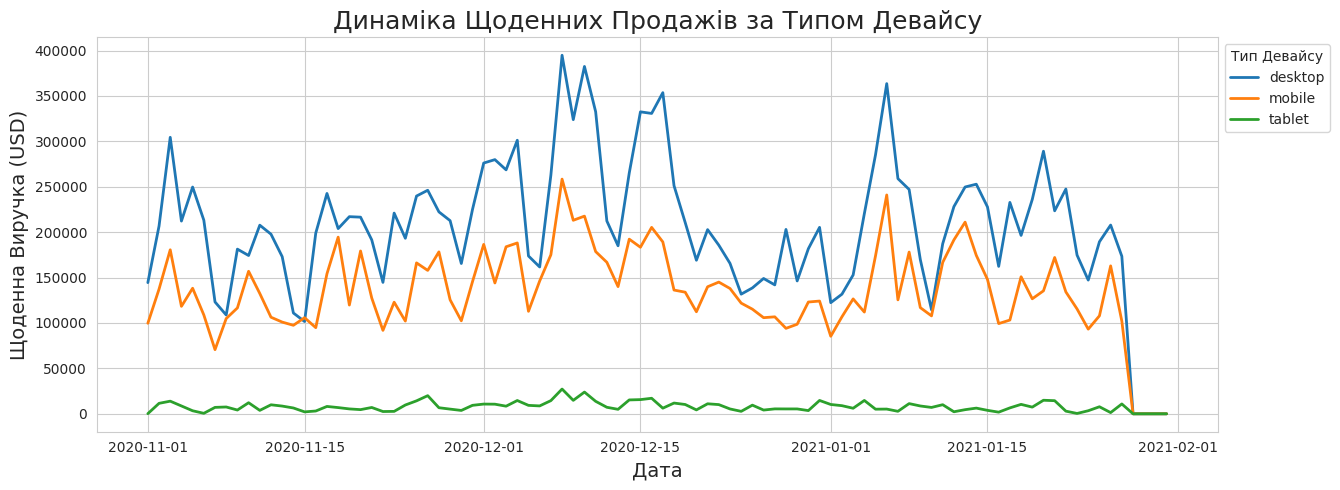

In [ ]:
# Налаштування стилю
sns.set_style("whitegrid")
plt.figure(figsize=(15, 5))

# Побудова лінійного графіку
sns.lineplot(
    x='date',
    y='Daily_Revenue',
    hue='device',
    data=daily_device_sales,
    linewidth=2
)

# Заголовок та підписи осей
plt.title('Динаміка Щоденних Продажів за Типом Девайсу', fontsize=18)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Щоденна Виручка (USD)', fontsize=14)

# Розташування легенди
plt.legend(title='Тип Девайсу', loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

На графіку ми бачимо, що більшість замовлень оформлюється з десктопу. Замовлення з мобільних пристроїв також вносять суттєвий вклад, а замовлення з планшетів майже не помітні на фоні десктопу та мобільних пристроїв.

###**6. Зведені таблиці**

###1) Кількість сесій у розрізі каналів трафіку та типів девайсів

In [ ]:
# 1. Фільтрація
df_filtered = sales_df.dropna(subset=['channel', 'device']).copy()

# 2. Створення зведеної таблиці
sessions_crosstab = pd.crosstab(
    index=df_filtered['channel'],
    columns=df_filtered['device'],
    rownames=['Traffic Channel'],
    colnames=['Device Type']
)

print("--- Зведена Таблиця: Кількість Сесій за Каналами та Девайсами ---")
print(sessions_crosstab)

--- Зведена Таблиця: Кількість Сесій за Каналами та Девайсами ---
Device Type      desktop  mobile  tablet
Traffic Channel                         
Direct             47825   31745    1812
Organic Search     72622   49014    2789
Paid Search        55167   37034    2140
Social Search      16288   10988     638
Undefined          12527    8486     470


###2) Загальні продажі за категоріями товарів (топ-10 категорій) у різних країнах (топ-5 країн)

In [ ]:
# 1. Перерахунок Топ-5 Країн за загальною виручкою
top5_countries = sales_df.groupby('country').agg(
    Total_Sales=('price', 'sum')
).nlargest(5, 'Total_Sales').index.tolist()

# 2. Перерахунок Топ-10 Категорій за загальною виручкою
top10_cats = sales_df.groupby('category').agg(
    Total_Revenue=('price', 'sum')
).nlargest(10, 'Total_Revenue').index.tolist()

# 3. Фільтрація: Залишаємо лише вибрані країни та категорії
df_filtered_geo_cat = sales_df[
    sales_df['country'].isin(top5_countries) &
    sales_df['category'].isin(top10_cats)
].copy()

In [ ]:
# 4. Створення зведеної таблиці
sales_pivot = pd.pivot_table(
    df_filtered_geo_cat,
    values='price',
    index='country',
    columns='category',
    aggfunc='sum',
    fill_value=0
)

# 5. Сортування стовпців
column_order = sales_pivot.sum().sort_values(ascending=False).index
sales_pivot_sorted = sales_pivot[column_order]

print("\n--- Зведена Таблиця: Загальні Продажі (USD) ---")
print(sales_pivot_sorted)


--- Зведена Таблиця: Загальні Продажі (USD) ---
category        Sofas & armchairs     Chairs       Beds  \
country                                                   
Canada                   692427.5   417740.8   354772.0   
France                   187735.0   134029.4   116414.0   
India                    788430.0   544309.2   358319.5   
United Kingdom           234812.0   188519.4   133816.0   
United States           3707144.5  2619773.8  2213058.0   

category        Bookcases & shelving units  Cabinets & cupboards  \
country                                                            
Canada                            278981.9              181802.0   
France                             73830.0               59101.5   
India                             364507.4              191888.0   
United Kingdom                    113987.6               71684.5   
United States                    1567606.9              994545.5   

category        Outdoor furniture  Tables & desks  \
country

###3) Кількість унікальних користувачів за статусом верифікації

In [ ]:
# Використовуємо df_filtered_geo_cat з Топ-5 Країн

verification_pivot = pd.pivot_table(
    df_filtered_geo_cat.dropna(subset=['is_verified']),
    values='account_id',
    index='country',
    columns='is_verified',
    aggfunc=pd.Series.nunique,
    fill_value=0
)

print("\n--- Зведена Таблиця: Унікальні Користувачі за Статусом Верифікації (Топ-5 Країн) ---")
print(verification_pivot)


--- Зведена Таблиця: Унікальні Користувачі за Статусом Верифікації (Топ-5 Країн) ---
is_verified       0    1
country                 
Canada           49  150
France           10   45
India            71  164
United Kingdom   29   57
United States   344  829


###**7. Статистичний аналіз взаємозв’язків**

###1) Взаємозв’язок між кількістю сесій та загальними продажами

In [ ]:
daily_metrics = sales_df.groupby('date').agg(
    Daily_Sessions=('ga_session_id', 'nunique'),
    Daily_Revenue=('price', 'sum')
).reset_index()

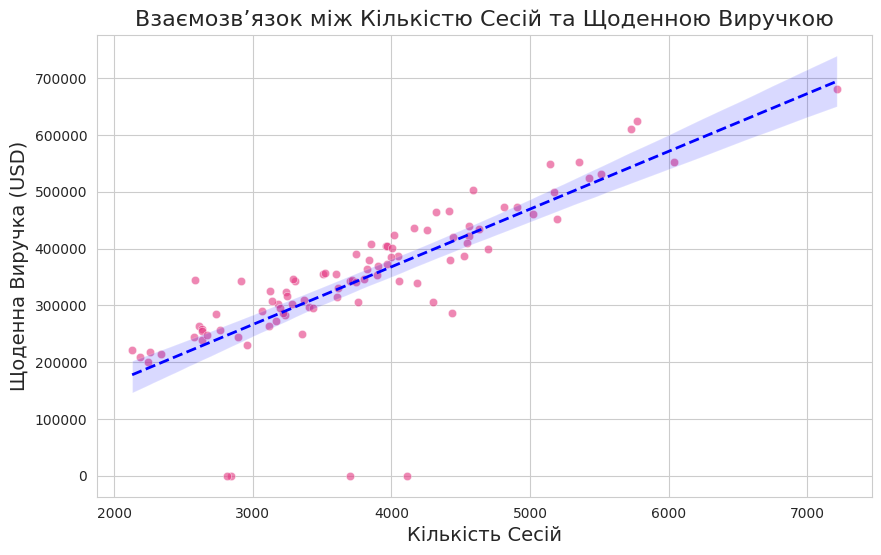

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Побудова діаграми розсіювання
sns.scatterplot(
    x='Daily_Sessions',
    y='Daily_Revenue',
    data=daily_metrics,
    color='#e43881',
    alpha=0.6
)

# Додавання лінії тренду для візуальної оцінки
sns.regplot(
    x='Daily_Sessions',
    y='Daily_Revenue',
    data=daily_metrics,
    scatter=False,
    color='blue',
    line_kws={'linestyle': '--', 'linewidth': 2}
)

plt.title('Взаємозв’язок між Кількістю Сесій та Щоденною Виручкою', fontsize=16)
plt.xlabel('Кількість Сесій', fontsize=14)
plt.ylabel('Щоденна Виручка (USD)', fontsize=14)
plt.show()

In [ ]:
# 1. Розрахунок кореляції та p-значення
correlation_r, p_value = pearsonr(
    daily_metrics['Daily_Sessions'],
    daily_metrics['Daily_Revenue'])

# 2. Вивід результатів
print(f"Коефіцієнт кореляції Пірсона (r): {correlation_r:.4f}")
print(f"P-значення: {p_value:.4e}")

Коефіцієнт кореляції Пірсона (r): 0.7911
P-значення: 6.4835e-21


Коефіцієнт кореляції Пірсона  = 0.7911 є дуже високим показником і свідчить про наявність сильного позитивного лінійного зв'язку між трафіком (сесіями) та виручкою. P-значення підтверджує, що цей показник э статистично значущим.

###2) Кореляція продажів між різними континентами

In [ ]:
# 1. Визначаємо Топ-3 континети
top3_continents = sales_df.groupby('continent')['price'].sum().nlargest(3).index.tolist()

# 2. Створюємо таблицю
continent_daily_sales = sales_df[sales_df['continent'].isin(top3_continents)].pivot_table(
    index='date',
    columns='continent',
    values='price',
    aggfunc='sum'
).fillna(0)

# 3. Розрахунок кореляції та p-значень
corr_matrix = continent_daily_sales.corr()
p_values = pd.DataFrame(np.ones(corr_matrix.shape), columns=corr_matrix.columns, index=corr_matrix.index)

for i in range(len(top3_continents)):
    for j in range(len(top3_continents)):
        if i != j:
            c1, c2 = top3_continents[i], top3_continents[j]
            _, p = pearsonr(continent_daily_sales[c1], continent_daily_sales[c2])
            p_values.loc[c1, c2] = p

print("--- Матриця кореляції Пірсона (r) ---")
print(corr_matrix)
print("\n--- Матриця P-значень (значущість) ---")
print(p_values)

--- Матриця кореляції Пірсона (r) ---
continent  Americas      Asia    Europe
continent                              
Americas   1.000000  0.792025  0.770586
Asia       0.792025  1.000000  0.768427
Europe     0.770586  0.768427  1.000000

--- Матриця P-значень (значущість) ---
continent      Americas          Asia        Europe
continent                                          
Americas   1.000000e+00  5.409189e-21  2.671449e-19
Asia       5.409189e-21  1.000000e+00  3.864946e-19
Europe     2.671449e-19  3.864946e-19  1.000000e+00


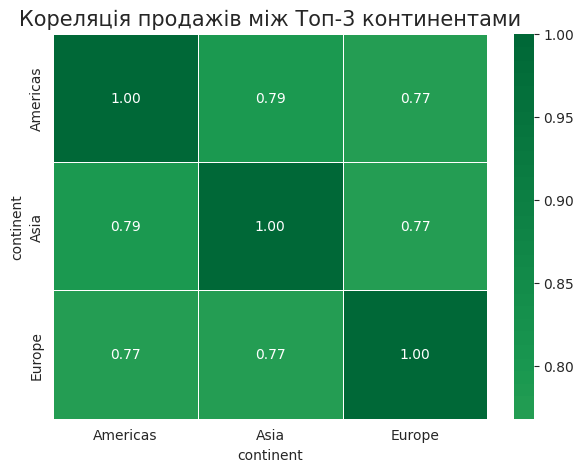

In [ ]:
plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, fmt=".2f", linewidths=0.5)
plt.title('Кореляція продажів між Топ-3 континентами', fontsize=15)
plt.show()

Теплова карта вказує на сильну позитивну кореляцію між континентами в розрізі продаж. Продажі на різних континентах рухаються майже унісонно. Це дозволяє масштабувати успішні рішення з одного континенту на інші без значних коригувань.

###3) Кореляція продажів між різними каналами трафіку

In [ ]:
# 1. Визначаємо основні канали
significant_channels = ['Organic Search', 'Paid Search', 'Direct', 'Social Search']

# 2. Створюємо таблицю
channel_daily_sales = sales_df.pivot_table(
    index='date',
    columns='channel',
    values='price',
    aggfunc='sum'
)

# Фільтруємо таблицю
channel_daily_sales = channel_daily_sales[significant_channels].fillna(0)

# 3. Розрахунок кореляції Пірсона (r)
corr_matrix_channel = channel_daily_sales.corr()

# 4. Розрахунок P-значень (статистична значущість)
p_values_channel = pd.DataFrame(np.ones(corr_matrix_channel.shape),
                                columns=corr_matrix_channel.columns,
                                index=corr_matrix_channel.index)

# Обчислення p-значень для кожної унікальної пари
channels_list = corr_matrix_channel.columns
for i in range(len(channels_list)):
    for j in range(i + 1, len(channels_list)):
        c1, c2 = channels_list[i], channels_list[j]
        r, p = pearsonr(channel_daily_sales[c1], channel_daily_sales[c2])
        p_values_channel.loc[c1, c2] = p
        p_values_channel.loc[c2, c1] = p

print("--- Матриця кореляції Пірсона (r) ---")
print(corr_matrix_channel.round(2))
print("\n--- Матриця P-значень (Статистична значущість) ---")
print(p_values_channel.round(4))

--- Матриця кореляції Пірсона (r) ---
channel         Organic Search  Paid Search  Direct  Social Search
channel                                                           
Organic Search            1.00         0.87    0.84           0.58
Paid Search               0.87         1.00    0.81           0.60
Direct                    0.84         0.81    1.00           0.60
Social Search             0.58         0.60    0.60           1.00

--- Матриця P-значень (Статистична значущість) ---
channel         Organic Search  Paid Search  Direct  Social Search
channel                                                           
Organic Search             1.0          0.0     0.0            0.0
Paid Search                0.0          1.0     0.0            0.0
Direct                     0.0          0.0     1.0            0.0
Social Search              0.0          0.0     0.0            1.0


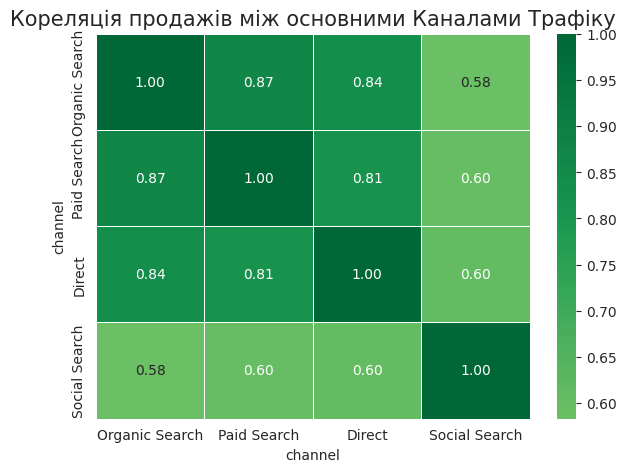

In [ ]:
plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix_channel, annot=True, cmap='RdYlGn', center=0, fmt=".2f", linewidths=0.5)
plt.title('Кореляція продажів між основними Каналами Трафіку', fontsize=15)
plt.show()

На тепловій карті ми бачимо сильну позитивну кореляцію. Ми можемо зробити висновок, що канали синергують. Зростання продажів через один канал стимулює зростання продажів через інший.

###4) Кореляція продажів між топовими категоріями товарів

In [ ]:
# 1. Визначаємо Топ-5 Категорій за загальною виручкою
top5_categories = sales_df.groupby('category')['price'].sum().nlargest(5).index.tolist()

# 2. Створюємо таблицю: дати в рядках, категорії в стовпцях
category_daily_sales = sales_df[sales_df['category'].isin(top5_categories)].pivot_table(
    index='date',
    columns='category',
    values='price',
    aggfunc='sum'
).fillna(0)

# 3. Розрахунок кореляції Пірсона (r)
corr_matrix_cat = category_daily_sales.corr()

# 4. Розрахунок P-значень (статистична значущість)
p_values_cat = pd.DataFrame(np.ones(corr_matrix_cat.shape),
                            columns=corr_matrix_cat.columns,
                            index=corr_matrix_cat.index)

categories_list = corr_matrix_cat.columns
for i in range(len(categories_list)):
    for j in range(i + 1, len(categories_list)):
        c1, c2 = categories_list[i], categories_list[j]
        r, p = pearsonr(category_daily_sales[c1], category_daily_sales[c2])
        p_values_cat.loc[c1, c2] = p
        p_values_cat.loc[c2, c1] = p

print(f"--- Топ-5 Категорій: {top5_categories} ---")

print("\n--- Матриця кореляції Пірсона (r) ---")
print(corr_matrix_cat.round(2))

print("\n--- Матриця P-значень (Статистична значущість) ---")
print(p_values_cat.to_string(float_format='{:,.4e}'.format))

--- Топ-5 Категорій: ['Sofas & armchairs', 'Chairs', 'Beds', 'Bookcases & shelving units', 'Cabinets & cupboards'] ---

--- Матриця кореляції Пірсона (r) ---
category                    Beds  Bookcases & shelving units  \
category                                                       
Beds                        1.00                        0.59   
Bookcases & shelving units  0.59                        1.00   
Cabinets & cupboards        0.51                        0.54   
Chairs                      0.55                        0.64   
Sofas & armchairs           0.54                        0.67   

category                    Cabinets & cupboards  Chairs  Sofas & armchairs  
category                                                                     
Beds                                        0.51    0.55               0.54  
Bookcases & shelving units                  0.54    0.64               0.67  
Cabinets & cupboards                        1.00    0.57               0.66  
Cha

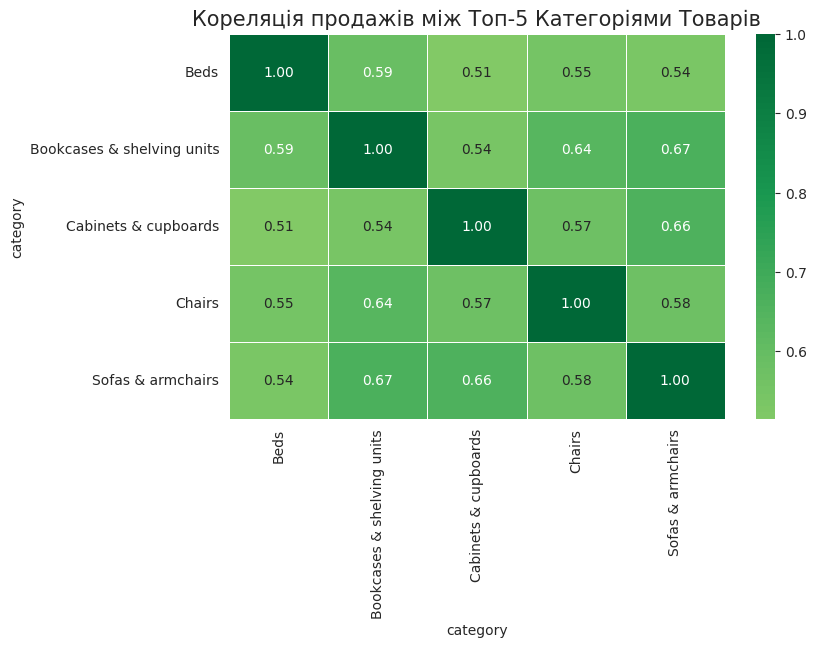

In [ ]:
plt.figure(figsize=(8, 5))
sns.heatmap(corr_matrix_cat, annot=True, cmap='RdYlGn', center=0, fmt=".2f", linewidths=0.5)
plt.title('Кореляція продажів між Топ-5 Категоріями Товарів', fontsize=15)
plt.show()

Отримані коефіцієнти кореляції Пірсона ($r$) в діапазоні $0.51$ до $0.67$ є помірно високими і свідчать про істотний, але не ідеальний, позитивний лінійний зв'язок між продажами цих пар категорій. Це може вказувати, що товари із цих категорій можуть бути допоненням одне до іншого або на спільну сезонність.

###5) Кореляція продажів між різними країнами

In [ ]:
# 1. Визначаємо Топ-5 Країн за загальною виручкою
top5_countries_corr = sales_df.groupby('country')['price'].sum().nlargest(5).index.tolist()

# 2. Створюємо таблицю: дати в рядках, країни в стовпцях
country_daily_sales = sales_df[sales_df['country'].isin(top5_countries_corr)].pivot_table(
    index='date',
    columns='country',
    values='price',
    aggfunc='sum'
).fillna(0)

# 3. Розрахунок кореляції Пірсона (r)
corr_matrix_country = country_daily_sales.corr()

# 4. Розрахунок P-значень (статистична значущість)
p_values_country = pd.DataFrame(np.ones(corr_matrix_country.shape),
                            columns=corr_matrix_country.columns,
                            index=corr_matrix_country.index)

countries_list = corr_matrix_country.columns
for i in range(len(countries_list)):
    for j in range(i + 1, len(countries_list)):
        c1, c2 = countries_list[i], countries_list[j]
        r, p = pearsonr(country_daily_sales[c1], country_daily_sales[c2])
        p_values_country.loc[c1, c2] = p
        p_values_country.loc[c2, c1] = p

print(f"--- Топ-5 Країн: {top5_countries_corr} ---")

print("\n--- Матриця кореляції Пірсона (r) ---")
print(corr_matrix_country.round(2))

print("\n--- Матриця P-значень (Статистична значущість) ---")
print(p_values_country.to_string(float_format='{:,.4e}'.format))

--- Топ-5 Країн: ['United States', 'India', 'Canada', 'United Kingdom', 'France'] ---

--- Матриця кореляції Пірсона (r) ---
country         Canada  France  India  United Kingdom  United States
country                                                             
Canada            1.00    0.39   0.50            0.36           0.67
France            0.39    1.00   0.36            0.25           0.47
India             0.50    0.36   1.00            0.46           0.68
United Kingdom    0.36    0.25   0.46            1.00           0.46
United States     0.67    0.47   0.68            0.46           1.00

--- Матриця P-значень (Статистична значущість) ---
country            Canada     France      India  United Kingdom  United States
country                                                                       
Canada         1.0000e+00 1.1668e-04 3.6306e-07      4.3313e-04     1.7171e-13
France         1.1668e-04 1.0000e+00 3.9473e-04      1.4286e-02     2.9548e-06
India          3.6306e-0

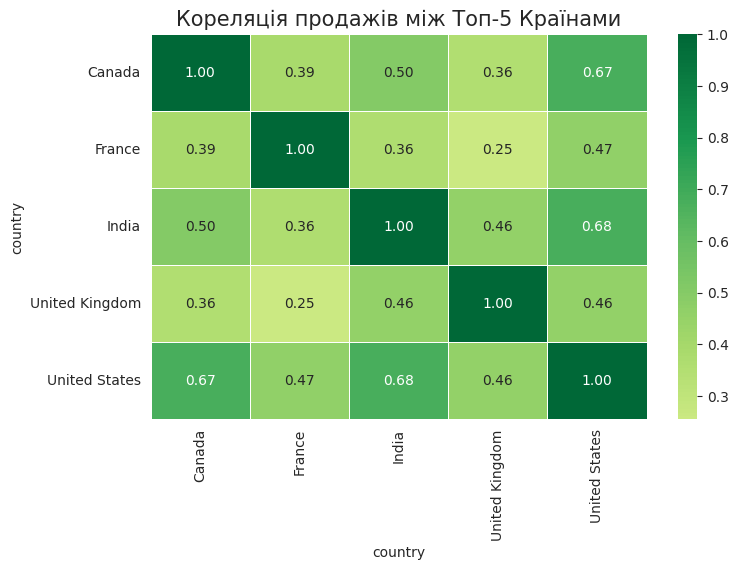

In [ ]:
plt.figure(figsize=(8, 5))
sns.heatmap(corr_matrix_country, annot=True, cmap='RdYlGn', center=0, fmt=".2f", linewidths=0.5)
plt.title('Кореляція продажів між Топ-5 Країнами', fontsize=15)
plt.show()

Показник кореляції варіюється від 0.25 до 0.68.\
Між Францією та Британією ми маємо показник кореляції 0.25 - слабка кореляція. Продажі у Франції та Британії розвиваються незалежно один від одного. Те, що є піком продажів в одній країні, не обов'язково є піком в іншій.\
У парах Індія - США, Канада - США  показник кореляції близький до 0.7 - сильна позитивна кореляція. Значення вказують на те, що щоденна динаміка продажів у цих парах країн є дуже схожою. Зростання продажів у США майже завжди супроводжується зростанням у Канаді та Індії.

###8. **Статистичний аналіз відмінностей між групами**

###1) Порівняння продажів зараєстрованих та незареєстрованих користувачів

In [ ]:
# 1. Створення вибірок (фільтрація та агрегація)
# Видаляємо рядки, де статус is_verified невідомий
df_verified = sales_df.dropna(subset=['is_verified']).copy()

# Створення двох вибірок щоденної виручки
daily_sales_verified = df_verified[df_verified['is_verified'] == 1].groupby('date')['price'].sum().reset_index()
daily_sales_unverified = df_verified[df_verified['is_verified'] == 0].groupby('date')['price'].sum().reset_index()

# Перейменування стовпців для зручності
daily_sales_verified.rename(columns={'price': 'Verified_Revenue'}, inplace=True)
daily_sales_unverified.rename(columns={'price': 'Unverified_Revenue'}, inplace=True)

# Об'єднання в один DataFrame (для синхронізації дат)
combined_daily_sales = pd.merge(daily_sales_verified, daily_sales_unverified, on='date', how='outer').fillna(0)

# Фінальні вибірки для аналізу
sample_verified = combined_daily_sales['Verified_Revenue']
sample_unverified = combined_daily_sales['Unverified_Revenue']

print("--- Огляд вибірок: Статистичні показники ---")
print("Зареєстровані (Verified):")
print(sample_verified.describe())
print("\nНезареєстровані (Unverified):")
print(sample_unverified.describe())

--- Огляд вибірок: Статистичні показники ---
Зареєстровані (Verified):
count       88.000000
mean     21204.743182
std       8259.137448
min       3379.000000
25%      15127.250000
50%      20633.900000
75%      25708.550000
max      44802.400000
Name: Verified_Revenue, dtype: float64

Незареєстровані (Unverified):
count       88.000000
mean      8142.057955
std       5624.238590
min        535.000000
25%       4762.875000
50%       7344.500000
75%      10448.500000
max      37220.000000
Name: Unverified_Revenue, dtype: float64


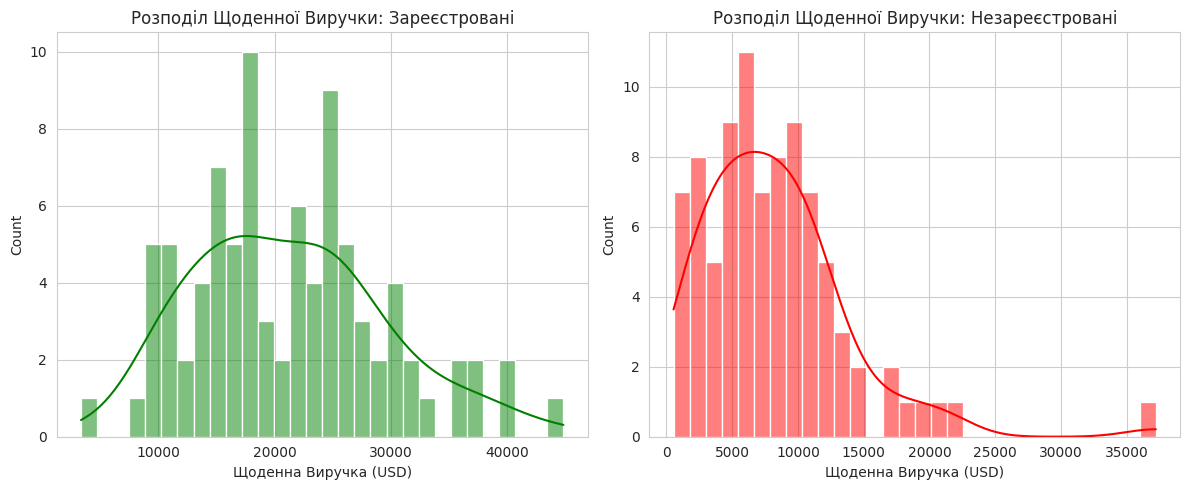

In [ ]:
# Візуалізація розподілу
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(sample_verified, kde=True, color='green', bins=30)
plt.title('Розподіл Щоденної Виручки: Зареєстровані')
plt.xlabel('Щоденна Виручка (USD)')

plt.subplot(1, 2, 2)
sns.histplot(sample_unverified, kde=True, color='red', bins=30)
plt.title('Розподіл Щоденної Виручки: Незареєстровані')
plt.xlabel('Щоденна Виручка (USD)')

plt.tight_layout()
plt.show()

In [ ]:
# Проведення тесту Манна-Уітні
from scipy.stats import mannwhitneyu

# Проведення тесту
statistic, p_value = mannwhitneyu(sample_verified, sample_unverified, alternative='two-sided')

print("\n--- Результати Тесту Манна-Уітні ---")
print(f"Статистика тесту (U): {statistic:.2f}")
print(f"P-значення: {p_value:.4e}")


--- Результати Тесту Манна-Уітні ---
Статистика тесту (U): 7147.00
P-значення: 3.3673e-22


На графіку видно, що ні один з розподілів не є нормальним. Тому для визначення статистичої значущості був використаний тест Манна-Уітні.\
Висновок: Існує статистично значуща різниця (P < 0.05) між медіанами щоденної виручки зареєстрованих та незареєстрованих користувачів. Так як медіана зареєстрованих (\$20634) більше ніж незареєстрованих ($7345), робимо висновок, що медіанний дохід більше від зареєстрованих користувачів.


### 2) Аналіз кількості сесій за різними каналами трафіку

In [ ]:
from scipy.stats import kruskal, shapiro

# 1. Агрегація даних
daily_sessions_by_channel = sales_df.groupby(['date', 'channel'])['ga_session_id'].count().reset_index()
daily_sessions_by_channel.rename(columns={'ga_session_id': 'Daily_Sessions'}, inplace=True)

# 2. Створення словника вибірок для аналізу
channel_samples = {}
# Визначаємо список каналів для аналізу
significant_channels = daily_sessions_by_channel['channel'].value_counts().nlargest(4).index.tolist()

for channel in significant_channels:
    sample = daily_sessions_by_channel[daily_sessions_by_channel['channel'] == channel]['Daily_Sessions']
    channel_samples[channel] = sample.fillna(0)

print(f"--- Канали Трафіку для Аналізу: {significant_channels} ---")

# 3. Огляд розподілу (описова статистика)
print("\n--- Описова статистика щоденних сесій за каналами ---")
for channel, sample in channel_samples.items():
    print(f"\nКанал: {channel}")
    print(sample.describe())

--- Канали Трафіку для Аналізу: ['Direct', 'Organic Search', 'Paid Search', 'Social Search'] ---

--- Описова статистика щоденних сесій за каналами ---

Канал: Direct
count          92.0
mean     884.586957
std      220.225267
min           481.0
25%           744.0
50%           869.5
75%         1004.75
max          1668.0
Name: Daily_Sessions, dtype: Float64

Канал: Organic Search
count           92.0
mean     1352.445652
std       336.572261
min            733.0
25%          1117.25
50%           1329.0
75%          1558.75
max           2589.0
Name: Daily_Sessions, dtype: Float64

Канал: Paid Search
count           92.0
mean     1025.445652
std         254.4211
min            578.0
25%           860.25
50%            989.0
75%          1171.75
max           1959.0
Name: Daily_Sessions, dtype: Float64

Канал: Social Search
count          92.0
mean     303.413043
std       88.127923
min           137.0
25%           235.5
50%           308.0
75%          358.25
max           561.0
N

In [ ]:
# Перевірка на нормальність розподілу (Тест Шапіро-Уілка)
print("\n--- Результати Тесту Шапіро-Уілка на Нормальність (H0: Розподіл Нормальний) ---")
alpha = 0.05
test_results = {}

for channel, sample in channel_samples.items():
    # Тест Шапіро-Уілка вимагає, щоб вибірка була достатньо великою (зазвичай > 3)
    if len(sample) > 3:
        statistic, p_value = shapiro(sample)
        test_results[channel] = {'W_Statistic': statistic, 'P_Value': p_value}

        conclusion = "Не нормальний (P < 0.05)" if p_value < alpha else "Нормальний (P >= 0.05)"
        print(f"Канал: {channel}")
        print(f"  W-статистика: {statistic:.4f}")
        print(f"  P-значення: {p_value:.4e}")
        print(f"  Висновок: {conclusion}")
    else:
        print(f"Канал: {channel} - Недостатньо даних для тесту Шапіро-Уілка.")
    print("-" * 40)


--- Результати Тесту Шапіро-Уілка на Нормальність (H0: Розподіл Нормальний) ---
Канал: Direct
  W-статистика: 0.9704
  P-значення: 3.4279e-02
  Висновок: Не нормальний (P < 0.05)
----------------------------------------
Канал: Organic Search
  W-статистика: 0.9641
  P-значення: 1.2272e-02
  Висновок: Не нормальний (P < 0.05)
----------------------------------------
Канал: Paid Search
  W-статистика: 0.9633
  P-значення: 1.0833e-02
  Висновок: Не нормальний (P < 0.05)
----------------------------------------
Канал: Social Search
  W-статистика: 0.9789
  P-значення: 1.4127e-01
  Висновок: Нормальний (P >= 0.05)
----------------------------------------


In [ ]:
# Проведення тесту Краскела-Уолліса
sample_values = [sample.values for sample in channel_samples.values()]

statistic, p_value = kruskal(*sample_values)

print("\n--- Результати Тесту Краскела-Уолліса (Порівняння Медіан Сесій) ---")
print(f"Статистика тесту (H): {statistic:.2f}")
print(f"P-значення: {p_value:.4e}")

# Висновок
alpha = 0.05
if p_value < alpha:
    print(f"\nВисновок: Відхиляємо H0. Існує статистично значуща різниця (P < {alpha}) між медіанами щоденної кількості сесій у різних каналах трафіку.")
else:
    print(f"\nВисновок: Не відхиляємо H0. Статистично значущої різниці (P >= {alpha}) між медіанами щоденної кількості сесій не виявлено. Усі канали залучають трафік з однаковою медіанною інтенсивністю.")


--- Результати Тесту Краскела-Уолліса (Порівняння Медіан Сесій) ---
Статистика тесту (H): 260.48
P-значення: 3.5370e-56

Висновок: Відхиляємо H0. Існує статистично значуща різниця (P < 0.05) між медіанами щоденної кількості сесій у різних каналах трафіку.


Завдяки тесту Шапіро-Уілка ми перевірили розподіли на нормальність. Тест показав, що тільки один з розподілів є нормальним. Тому для перевірки статистичної значущості ми вирористали тест Краскела-Уолліса, який показав що різниця хоча б у однієї пари каналів є значущою.\
Щоб точно вияснити між якими каналами різниця є статистичо значущою використаєм тест Данна.

In [ ]:
from scikit_posthocs import posthoc_dunn

# 1. Підготовка даних у форматі, що підходить для тесту Данна
sample_values_list = [sample.values for sample in channel_samples.values()]

# 2. Проведення тесту Данна
posthoc_results = posthoc_dunn(
    a=sample_values_list,
    p_adjust='bonferroni'
)

# Додавання назв каналів для зручності читання
posthoc_results.columns = significant_channels
posthoc_results.index = significant_channels

print("\n--- Результати Post-Hoc Тесту Данна (Bonferroni-корекція P-значень) ---")
# Виводимо результати з науковою нотацією для точності
print(posthoc_results.to_string(float_format='{:,.4e}'.format))


--- Результати Post-Hoc Тесту Данна (Bonferroni-корекція P-значень) ---
                   Direct  Organic Search  Paid Search  Social Search
Direct         1.0000e+00      2.3572e-12   6.9279e-02     1.5660e-16
Organic Search 2.3572e-12      1.0000e+00   1.3320e-05     6.5352e-55
Paid Search    6.9279e-02      1.3320e-05   1.0000e+00     2.6038e-27
Social Search  1.5660e-16      6.5352e-55   2.6038e-27     1.0000e+00


Завдяки цьому тесту ми бачимо, що різниця у трафіку є значущою між усіма каналами окрім пари Paid Search  - Direct. p-value = 0.069, тому робимо висновок, що медіанний обсяг щоденних сесій від Direct та Paid Search статистично не відрізняється.

###3) Порівняння долі сесій з органічним трафіком у Європі та Америці

In [ ]:
from scipy.stats import norm

# 1.1. Агрегація даних
daily_sessions_agg = sales_df.groupby(['date', 'continent', 'channel'])['ga_session_id'].count().reset_index()
daily_sessions_agg.rename(columns={'ga_session_id': 'Sessions'}, inplace=True)

# 1.2. Визначення загальної кількості сесій на день для кожного континенту
total_daily_sessions = daily_sessions_agg.groupby(['date', 'continent'])['Sessions'].sum().reset_index()
total_daily_sessions.rename(columns={'Sessions': 'Total_Sessions'}, inplace=True)

# 1.3. Визначення кількості органічних сесій на день для кожного континенту
organic_daily_sessions = daily_sessions_agg[daily_sessions_agg['channel'] == 'Organic Search'].copy()
organic_daily_sessions.rename(columns={'Sessions': 'Organic_Sessions'}, inplace=True)

# 1.4. Об'єднання та розрахунок щоденної частки органічного трафіку
df_proportions = pd.merge(
    total_daily_sessions,
    organic_daily_sessions[['date', 'continent', 'Organic_Sessions']],
    on=['date', 'continent'],
    how='left'
).fillna(0) # Заповнюємо 0, якщо в певний день органічного трафіку не було

# Розрахунок частки (пропорції)
df_proportions['Organic_Proportion'] = df_proportions['Organic_Sessions'] / df_proportions['Total_Sessions']
# Замінюємо NaN (виникає, якщо Total_Sessions=0) на 0
df_proportions['Organic_Proportion'].fillna(0, inplace=True)

# 1.5. Створення фінальних вибірок
europe_proportions = df_proportions[df_proportions['continent'] == 'Europe']['Organic_Proportion']
america_proportions = df_proportions[df_proportions['continent'] == 'Americas']['Organic_Proportion']

print("--- Огляд щоденної частки органічного трафіку ---")
print("\nEurope:")
print(europe_proportions.describe())
print("\nAmericas:")
print(america_proportions.describe())

--- Огляд щоденної частки органічного трафіку ---

Europe:
count        92.0
mean     0.357139
std      0.020514
min      0.316225
25%      0.341968
50%       0.35518
75%      0.372402
max      0.403475
Name: Organic_Proportion, dtype: Float64

Americas:
count        92.0
mean     0.355849
std      0.013967
min       0.32597
25%      0.348587
50%      0.355324
75%       0.36257
max       0.39071
Name: Organic_Proportion, dtype: Float64


/tmp/ipython-input-2883426751.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_proportions['Organic_Proportion'].fillna(0, inplace=True)


Перевірка вибірок на нормальність за допомогою тесту Шапіро-Уілка

In [ ]:
# Тест Шапіро-Уілка для вибірок щоденної частки органічного трафіку
print("\n--- Результати Тесту Шапіро-Уілка (H0: Розподіл Нормальний) ---")
alpha = 0.05
test_results = {}

# 1. Європа
statistic_eu, p_value_eu = shapiro(europe_proportions)
conclusion_eu = "Не нормальний (P < 0.05)" if p_value_eu < alpha else "Нормальний (P >= 0.05)"

print("\n🌍 Європа (Europe):")
print(f"  W-статистика: {statistic_eu:.4f}")
print(f"  P-значення: {p_value_eu:.4e}")
print(f"  Висновок: {conclusion_eu}")
print("-" * 40)

# 2. Америка
statistic_am, p_value_am = shapiro(america_proportions)
conclusion_am = "Не нормальний (P < 0.05)" if p_value_am < alpha else "Нормальний (P >= 0.05)"

print("\n🇺🇸 Америка (Americas):")
print(f"  W-статистика: {statistic_am:.4f}")
print(f"  P-значення: {p_value_am:.4e}")
print(f"  Висновок: {conclusion_am}")
print("-" * 40)


--- Результати Тесту Шапіро-Уілка (H0: Розподіл Нормальний) ---

🌍 Європа (Europe):
  W-статистика: 0.9842
  P-значення: 3.3397e-01
  Висновок: Нормальний (P >= 0.05)
----------------------------------------

🇺🇸 Америка (Americas):
  W-статистика: 0.9754
  P-значення: 7.9480e-02
  Висновок: Нормальний (P >= 0.05)
----------------------------------------


In [ ]:
from scipy.stats import levene, ttest_ind

# Перевірка рівності дисперсій (Гомогенність)
stat_levene, p_levene = levene(europe_proportions, america_proportions, center='median')

print("\n--- Результати Тесту Левена (Рівність Дисперсій) ---")
print(f"Статистика Левена: {stat_levene:.4f}")
print(f"P-значення: {p_levene:.4e}")
print("-" * 40)

# Визначення, який t-тест використовувати
equal_var_assumption = p_levene >= 0.05
test_type = "Стандартний t-тест (при рівних дисперсіях)" if equal_var_assumption else "t-тест Уелча (при нерівних дисперсіях)"

print(f"Рішення щодо дисперсій: {test_type}")


--- Результати Тесту Левена (Рівність Дисперсій) ---
Статистика Левена: 15.1654
P-значення: 1.3817e-04
----------------------------------------
Рішення щодо дисперсій: t-тест Уелча (при нерівних дисперсіях)


In [ ]:
# Встановлюємо equal_var=False для t-тесту Уелча
equal_var_assumption = False
test_type = "t-тест Уелча (при нерівних дисперсіях)"

statistic_t, p_value_t = ttest_ind(
    europe_proportions,
    america_proportions,
    equal_var=equal_var_assumption
)

print("\n--- Результати Незалежного t-тесту Уелча ---")
print(f"Тип тесту: {test_type}")
print(f"t-статистика: {statistic_t:.4f}")
print(f"P-значення: {p_value_t:.4e}")
print("-" * 40)


--- Результати Незалежного t-тесту Уелча ---
Тип тесту: t-тест Уелча (при нерівних дисперсіях)
t-статистика: 0.4987
P-значення: 6.1867e-01
----------------------------------------


У цьому блоці ми перевірили різницю між долями трафіку органічного каналу в Європі та Америки. Провели тест на нормальність розподілу та t-тест статистичної значущості.\
Висновок: немає статистично значущою різниці у цьому випадку. Обидва регіони мають порівнянну ефективність органічного каналу.

In [ ]:
# Збереження в CSV
sales_df.to_csv("bigquery_data_for_tableau.csv", index=False)

from google.colab import files
files.download("bigquery_data_for_tableau.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Tableu:
https://public.tableau.com/app/profile/nikita.naumenko/viz/Analyticsdashboard_17673522003230/Analyticsdashboard